In [31]:
import os
os.environ['RAY_DEDUP_LOGS'] = '0'

import numpy as np
import shap
import matplotlib.pyplot as plt
import json

from tempfile import TemporaryDirectory
from typing import List, Dict, Any, Optional

from ray.rllib.models import ModelCatalog
from eprllib.examples.example_central_agent_files.policy_model import CustomTransformerModel
ModelCatalog.register_custom_model("custom_transformer", CustomTransformerModel)

from eprllib.Environment.Environment import Environment
from eprllib.Environment.EnvironmentConfig import EnvironmentConfig
from eprllib.Agents.Filters.DefaultFilter import DefaultFilter
from eprllib.Agents.Triggers.SetpointTriggers import AvailabilityTrigger, DualSetpointTriggerDiscreteAndAvailabilityTrigger_v2, DualSetpointContinuosAndConstantFlowTrigger
from eprllib.Agents.Triggers.AirMassFlowRateTriggers import AirMassFlowRateTrigger
from eprllib.Agents.Rewards.EnergyAndAshrae55SimpleModel import EnergyAndASHRAE55SimpleModel, EnergyAndASHRAE55SimpleModelEnded
from eprllib.Agents.Rewards.ASHRAE55SimpleModel import ASHRAE55SimpleModelEnded, ASHRAE55SimpleModel
from eprllib.Agents.Rewards.NygardFerguson1990 import NygardFerguson1990
from eprllib.Agents.Rewards.CEN15251 import CEN15251
from eprllib.Utils.filter_utils import desnormalization_minmax

from eprllib.Agents.Rewards.Coraci2021 import Coraci2021
from eprllib.Agents.Filters.CoraciObsSpace import CoraciObsSpaceFilter
from eprllib.AgentsConnectors.Coraci2021Connector import Coraci2021Connector

from eprllib.AgentsConnectors.DefaultConnector import DefaultConnector

from eprllib.Agents.AgentSpec import (
    AgentSpec,
    ObservationSpec,
    RewardSpec,
    ActionSpec,
    TriggerSpec,
    FilterSpec
)
from eprllib.examples.example_thermostat_files.curriculum_learning import episode_fn

from eprllib.PostProcess.Evaluation import generate_experience_V2
from eprllib.AgentsConnectors.BaseConnector import BaseConnector

with open("C:/Users/grhen/Documents/GitHub2/eprllib/src/eprllib/examples/example_thermostat_files/curriculum_evaluation.json", "r") as f:
    episode_config = json.load(f)

In [32]:
"""
Esta configuración debe coincidir con la de entrenamiento.
"""
experiment_name:str = "tesis"
name:str = "task1"

eprllib_config = EnvironmentConfig()
eprllib_config.generals(
    epjson_path = "src/eprllib/examples/example_central_agent_files/model.epJSON",
    epw_path = "src/eprllib/examples/example_central_agent_files/weathers/ESP_PV_San.Sebastian-Igueldo.080270_TMYx.2004-2018.epw",
    output_path = TemporaryDirectory("output","",'C:/Users/grhen/Documents/Resultados_RLforEP').name,
    ep_terminal_output = False,
    timeout = 10,
    evaluation = True,
)
eprllib_config.connector(
    connector_fn = Coraci2021Connector,
    connector_fn_config = {},
)
eprllib_config.agents(
    agents_config = {
        "HVAC": AgentSpec(
            observation = ObservationSpec(
                variables = [
                    ("Site Outdoor Air Drybulb Temperature", "Environment"),
                    # ("Site Outdoor Air Relative Humidity", "Environment"),
                    ("Zone Mean Air Temperature", "Thermal Zone"),
                    # ("Zone Air Relative Humidity", "Thermal Zone"),
                    ("Zone People Occupant Count", "Thermal Zone"),
                    # ("Zone Thermal Comfort Fanger Model PMV", "People"),
                    # ("Zone Operative Temperature", "Thermal Zone"),
                    # ("Zone Air Humidity Ratio", "Thermal Zone"),
                    # ("Cooling Coil Total Cooling Energy", "HeatPump Cooling Coil"),
                    # ("Heating Coil Heating Energy", "HeatPump HP Heating Coil"),
                    # ("Heating Coil Heating Energy", "HeatPump Sup Heat Coil"),
                    # ("Zone Thermal Comfort CEN 15251 Adaptive Model Category I Status", "People"),
                    # ("Zone Thermal Comfort CEN 15251 Adaptive Model Category II Status", "People"),
                    # ("Zone Thermal Comfort CEN 15251 Adaptive Model Category III Status", "People"),
                ],
                simulation_parameters = {
                    'hour': True,
                #     'day_of_week': True,
                #     'minutes': True,
                #     'day_of_year': True,
                #     # 'today_weather_horizontal_ir_at_time': True,
                },
                meters = [
                    # "Electricity:Building",
                    "Heating:DistrictHeatingWater",
                    "Cooling:DistrictCooling",
                ],
                use_actuator_state = True,
                use_one_day_weather_prediction = True,
                weather_prediction_hours = 12,
                prediction_variables = {
                    'outdoor_dry_bulb': True,
                },
                internal_variables = [
                    ("Zone Floor Area", "Thermal Zone"),
                ],
                # history_len=4,
                user_occupation_function = False,
                user_type = "Office schedule",
                zone_type = "daytime",
                probability_variation = -1.,
                probability_variation_evening_night_hours = -1.,
                occupation_schedule = ("Schedule:Constant", "Schedule Value", "occupancy_schedule"),
                user_occupation_forecast = False,
                occupation_prediction_hours = 3,
                summer_months = [11, 12, 1, 2],
                # other_obs = {
                #     "war_north": 0,  # Window-to-wall ratio north
                #     "war_south": 0,  # Window-to-wall ratio south
                #     "war_east": 0,   # Window-to-wall ratio east
                #     "war_west": 0,   # Window-to-wall ratio west
                #     "latitude": 0,  # Latitude
                #     "longitude": 0,  # Longitude
                #     # "elevation": 0,  # Elevation
                #     # "time_zone": 0,  # Time zone
                # }
            ),
            # action = ActionSpec(
            #     actuators = [
            #         ("Ideal Loads Air System", "Air Mass Flow Rate", "IdealHVAC"),
            #     ],
            # ),
            action = ActionSpec(
                actuators = [
                    ("Schedule:Compact", "Schedule Value", "heating_setpoint"),
                    ("Schedule:Compact", "Schedule Value", "cooling_setpoint"),
                    ("Schedule:Constant", "Schedule Value", "HVAC_OnOff"),
                    # ("Ideal Loads Air System", "Air Mass Flow Rate", "IdealHVAC"),
                    # ("Ideal Loads Air System", "Air Temperature", "IdealHVAC"),
                ],
            ),
            filter= FilterSpec(
                filter_fn = CoraciObsSpaceFilter,
                filter_fn_config = {},
            ),
            
            # trigger= TriggerSpec(
            #     trigger_fn = DualSetpointTriggerContinuosAndAvailabilityTrigger_v2,
            #     trigger_fn_config = {
            #         'temperature_range': (18, 25),
            #         'deadband': 2,
            #         'actuator_for_cooling': ("Schedule:Compact", "Schedule Value", "cooling_setpoint"),
            #         'actuator_for_heating': ("Schedule:Compact", "Schedule Value", "heating_setpoint"),
            #         'availability_actuator': ("Schedule:Constant", "Schedule Value", "HVAC_OnOff"),
            #         # 'actions_file_path': "C:/Users/grhen/Documents/acciones.csv"
            #     },
            # ),
            
            trigger= TriggerSpec(
                trigger_fn = DualSetpointTriggerDiscreteAndAvailabilityTrigger_v2,
                trigger_fn_config = {
                    'temperature_range': (18, 25),
                    "action_space_dim": 21,
                    'actuator_for_cooling': ("Schedule:Compact", "Schedule Value", "cooling_setpoint"),
                    'actuator_for_heating': ("Schedule:Compact", "Schedule Value", "heating_setpoint"),
                    'availability_actuator': ("Schedule:Constant", "Schedule Value", "HVAC_OnOff"),
                },
            ),
            
            reward = RewardSpec(
                reward_fn = Coraci2021,
                reward_fn_config = {
                    "thermal_zone": "Thermal Zone",
                    # 'people_name': "People",
                    "t_low": 20.0,
                    "t_high": 24.0,
                    "timesteptoreward": 1,
                    'beta': 0.8,
                    'cooling_name': "Cooling:DistrictCooling",
                    'heating_name': "Heating:DistrictHeatingWater"
                },
            ),
        ),
    }
)

eprllib_config.episodes(
    episode_fn = episode_fn,
    episode_fn_config = episode_config,
    # cut_episode_len = 2
)

assert eprllib_config.agents_config is not None, "Agents configuration is not defined."

env_config = eprllib_config.to_dict()

In [ ]:
checkpoint = "C:/Users/grhen/ray_results/tesis/20260109113546-task1/PPO-f5009_00000/checkpoint_000003"
policy_name = "single_policy"

# Generate experience
df = generate_experience_V2(
    env = Environment,
    env_config = env_config,
    rl_module_checpoints = {
        "HVAC": checkpoint
    },
    policy_names = {
        "HVAC": policy_name,
    },
    num_episodes = 1
)

In [34]:
feature_names: Dict[str, List[str]] = {agent: [] for agent in env_config["agents_config"].keys()}
feature_names_index: Dict[str, Dict[str, int]] = {agent: {} for agent in env_config["agents_config"].keys()}
connector_fn: BaseConnector = env_config['connector_fn'](env_config["connector_fn_config"])

for agent in env_config["agents_config"].keys():
    connector_fn.get_agent_obs_dim(env_config,agent)
    feature_names_index[agent] = connector_fn.get_agent_obs_indexed(env_config,agent)
    for key in feature_names_index[agent].keys():
        feature_names[agent].append(key)

for agent in feature_names.keys():
    if env_config["agents_config"][agent]["observation"]["history_len"] > 1:
        feature_names_h = feature_names[agent].copy()
        for h in range(env_config["agents_config"][agent]["observation"]["history_len"]):
            feature_names_h_new: List[str] = []
            for value in feature_names_h:
                feature_names_h_new.append(f"h{h}_{value}")
            feature_names[agent].extend(feature_names_h_new)

In [ ]:
# Reward function
def rew_fn(
    occupation: float,
    dt: float,
    energy: float,
    t_o: float,
    t_comfort: float = 21.,
    beta: float = 0.99
    ) -> float:
    # Create a variable to cumulate the energy and comfort reward for the timestep
    reward: float = 0.0
    
    # === ENERGY ===
    reward += -(1 - beta) * np.log10((energy)/abs(t_comfort - t_o) + 1)
    
    # If the place is occupied.
    if occupation != 0:
        # === COMFORT ===
        # Calculate the reward for the actual state.
        reward += - beta * np.clip(((dt)**3)/(2**3),0,1)
    
    # Save the time step reward to use it with timesteptoreward. 
    return reward

In [36]:
for agent in feature_names_index.keys():
    action_list_1: List[float] = []
    # action_list_2: List[float] = []
    av_list: List[int] = []
    # t_r_list: List[float] = []
    # t_c_list: List[float] = []
    t_i_list: List[float] = []
    occ_list: List[float] = []
    occ_list2: List[float] = []
    t_out_list: List[float] = []
    energy_list: List[float] = []
    # t_op_list: List[float] = []
    # hr_list: List[float] = []
    # pmv_list: List[float] = []
    # pmv_hist: List[float] = []
    rew_list: List[float] = []
    
    # temp_range = env_config["agents_config"][agent]["trigger"]["trigger_fn_config"]["temperature_range"]
    # temp_avg = (min(temp_range)+max(temp_range))/2
    
    for timestep in range(1,len(df["experiment"]["episode_1"])):
        if env_config["agents_config"][agent]["observation"]["history_len"] > 1:
            t_i_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: dt: 0"]]*10+(20+24)/2)
            t_out_list.append(desnormalization_minmax(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Site Outdoor Air Drybulb Temperature: Environment"]],-20+273.15,50+273.15)-273.15)
            # t_op_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Zone Operative Temperature: Thermal Zone"]])
            # hr_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Zone Air Humidity Ratio: Thermal Zone"]])
            energy_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]]*0.01*20)
            occ_t = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Zone People Occupant Count: Thermal Zone"]]
            if occ_t > 0:
                occ_list.append(occ_t)
                occ_list2.append(occ_t*33)
            #     # pmv_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
            #     # pmv_hist.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
            else:
                occ_list.append(0)
                occ_list2.append(0)
            #     # pmv_list.append(0)
            rew_list.append(rew_fn(
                occupation = float(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Zone People Occupant Count: Thermal Zone"]]),
                dt = float(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: dt: 0"]]*10),
                energy = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]],
                t_o = desnormalization_minmax(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][-1][feature_names_index[agent][f"{agent}: Site Outdoor Air Drybulb Temperature: Environment"]],-20+273.15,50+273.15)-273.15
                ))
        else:
            # t_i_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone Mean Air Temperature: Thermal Zone"]])
            t_i_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: dt: 0"]]*10+(20+24)/2)
            t_out_list.append(desnormalization_minmax(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Site Outdoor Air Drybulb Temperature: Environment"]],-20+273.15,50+273.15)-273.15)
            # t_op_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone Operative Temperature: Thermal Zone"]])
            # hr_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone Air Humidity Ratio: Thermal Zone"]])
            energy_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]]*0.01*20)
            occ_t = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone People Occupant Count: Thermal Zone"]]
            if occ_t > 0:
                occ_list.append(occ_t)
                occ_list2.append(occ_t*25)
            #     # pmv_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
            #     # pmv_hist.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
            else:
                occ_list.append(0)
                occ_list2.append(0)
            #     # pmv_list.append(0)
            rew_list.append(rew_fn(
                occupation = float(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Zone People Occupant Count: Thermal Zone"]]),
                dt = float(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: dt: 0"]]*10),
                energy = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]],
                t_o = desnormalization_minmax(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Site Outdoor Air Drybulb Temperature: Environment"]],-20+273.15,50+273.15)-273.15
                ))
        
        if df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"] is None:
            pass
        else:
            action_list_1.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"]/20)
            # a1 = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"][0]
            # a2 = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"][1]
            
            # if action < 0:
            #     action_list_1.append(0)
            # elif action > 1:
            #     action_list_1.append(1)
            # else:
            #     action_list_1.append(action[0])
            # action_list_2.append(a2)
            # temp_range = env_config["agents_config"][agent]["trigger"]["trigger_fn_config"]["temperature_range"]
            # action_range: int = env_config["agents_config"][agent]["trigger"]["trigger_fn_config"]["action_space_dim"]            
            # if action[0] <= 0.0:
            #     # t_r_list.append(float(min(temp_range)+ 2))
            #     # t_c_list.append(float(min(temp_range)))
            #     av_list.append(0)
            
            # elif action[0] >= 1.0:
            #     # t_r_list.append(float(min(temp_range) + (max(temp_range) - min(temp_range) - 2) + 2))
            #     # t_c_list.append(float(min(temp_range) + (max(temp_range) - min(temp_range) - 2)))
            #     av_list.append(1)
            
            # else:
            #     # t_r_list.append(float(min(temp_range) + (action)*(max(temp_range) - min(temp_range) - 2) + 2))
            #     # t_c_list.append(float(min(temp_range) + (action)*(max(temp_range) - min(temp_range) - 2)))
            #     av_list.append(action[0])
    

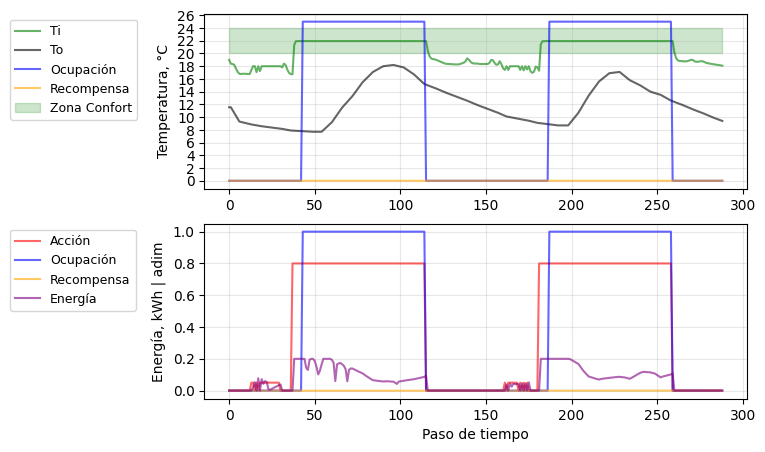

In [37]:
for agent in feature_names_index.keys():
    # 1. Time series plot
    plt.figure(figsize=(7, 5))
    plt.subplot(2, 1, 1)
    # plt.plot(t_r_list, label='Tr', color='blue', alpha=0.6)
    # plt.plot(t_c_list, label='Tc', color='red', alpha=0.6)
    # plt.plot(t_op_list, label='Top', color='red', alpha=0.6)
    plt.plot(t_i_list, label='Ti', color='green', alpha=0.6)
    plt.plot(t_out_list, label='To', color='black', alpha=0.6)
    plt.plot(occ_list2, label='Ocupación', color='blue', alpha=0.6)
    plt.plot(rew_list, label='Recompensa', color='orange', alpha=0.6)
    # Plot an area between 19 °C and 25 °C
    plt.fill_between(range(len(t_out_list)), 20, 24, color='green', alpha=0.2, label='Zona Confort')
    plt.ylabel('Temperatura, °C')
    plt.yticks(np.arange(0, 27, 2))
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(-0.37, 1), fontsize=9)
    
    plt.subplot(2, 1, 2)
    plt.plot(action_list_1, label='Acción', color='red', alpha=0.6)
    plt.plot(occ_list, label='Ocupación', color='blue', alpha=0.6)
    plt.plot(rew_list, label='Recompensa', color='orange', alpha=0.6)
    # plt.plot(pmv_list, label='PMV', color='green', alpha=0.6)
    plt.plot(energy_list, label='Energía', color='purple', alpha=0.6)
    plt.legend(loc='upper left', bbox_to_anchor=(-0.37, 1), fontsize=9)
    plt.xlabel('Paso de tiempo')
    plt.ylabel('Energía, kWh | adim')
    plt.grid(True, alpha=0.3)
    plt.show()

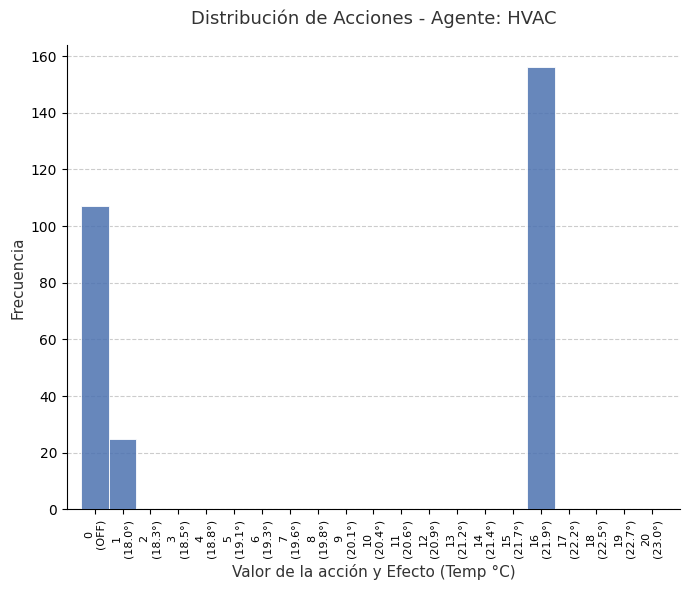

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que 'action_list_1' contiene los datos normalizados (0-1).
# Convertimos a numpy array y multiplicamos por 20 para obtener la escala real.
real_actions = np.array(action_list_1) * 20

for agent in feature_names_index.keys():
    # 2. Histogram
    plt.figure(figsize=(7, 6)) # Aumentamos el ancho para que las etiquetas no se solapen
    
    # --- Configuración de Bins Centrados (Escala 0-20) ---
    step = 1
    bins = np.arange(-0.5, 20.5 + step, step)
    
    # --- Gráfico ---
    plt.hist(real_actions, bins=bins, color='#4C72B0', edgecolor='white', linewidth=0.7, alpha=0.85, zorder=3)
    
    # --- Estética y Etiquetas ---
    plt.xlabel('Valor de la acción y Efecto (Temp °C)', fontsize=11, color='#333333')
    plt.ylabel('Frecuencia', fontsize=11, color='#333333')
    plt.title(f'Distribución de Acciones - Agente: {agent}', fontsize=13, pad=15, color='#333333')
    
    # Límites
    plt.xlim((-1, 21))
    
    # --- Configuración de Ticks Personalizados con Doble Etiqueta ---
    tick_locations = np.arange(0, 21, 1)
    tick_labels = []
    
    for action in tick_locations:
        if action == 0:
            # Acción 0: Apagado
            label = f"{action}\n(OFF)"
        else:
            # Acciones 1-20: Temperatura según la ecuación
            # T = 18 + ((action-1)/19)*(25-18-2) -> 25-18-2 = 5
            temp = 18 + ((action - 1) / 19) * 5
            label = f"{action}\n({temp:.1f}°)"
        tick_labels.append(label)

    # Aplicamos las etiquetas al eje X
    plt.xticks(tick_locations, tick_labels, fontsize=8, rotation='vertical') 
    plt.yticks(fontsize=10)
    
    # Grilla horizontal suave
    plt.grid(True, axis='y', linestyle='--', alpha=0.4, color='gray', zorder=0)
    
    # Remover bordes superior y derecho
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


In [39]:
# Basic statistical analysis
for agent in feature_names_index.keys():
    print(f"\nStatistical Summary ({agent}):")
    print(f"\nACTIONS")
    print(f"Action Mean: {np.mean(action_list_1):.2f}")
    print(f"Action Median: {np.median(action_list_1):.2f}")
    print(f"Action Std Dev: {np.std(action_list_1):.2f}")
    print(f"Action Min: {np.min(action_list_1):.2f}")
    print(f"Action Max: {np.max(action_list_1):.2f}")
    print(f"\nENERGY")
    print(f"Total Energy Consumption (kWh): {sum(energy_list):.2f}")
    print(f"\nREWARD")
    print(f"Total reward: {sum(rew_list)}")


Statistical Summary (HVAC):

ACTIONS
Action Mean: 0.44
Action Median: 0.80
Action Std Dev: 0.39
Action Min: 0.00
Action Max: 0.80

ENERGY
Total Energy Consumption (kWh): 19.71

REWARD
Total reward: -0.12940925805742154


In [40]:


agent:str = "HVAC"

feature_names_list: List[str] = feature_names[agent]

data_obs_list: List[Any] = []
for timestep in range(1,len(df["experiment"]["episode_1"])):
    data_obs_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"])
        
data_obs = np.array(data_obs_list)

In [41]:
feature_names_list

['HVAC: t_low',
 'HVAC: t_high',
 'HVAC: dt: -3',
 'HVAC: dt: -2',
 'HVAC: dt: -1',
 'HVAC: dt: 0',
 'HVAC: Site Outdoor Air Drybulb Temperature: Environment',
 'HVAC: outdoor_dry_bulb: 0',
 'HVAC: outdoor_dry_bulb: 1',
 'HVAC: outdoor_dry_bulb: 2',
 'HVAC: outdoor_dry_bulb: 3',
 'HVAC: outdoor_dry_bulb: 4',
 'HVAC: outdoor_dry_bulb: 5',
 'HVAC: outdoor_dry_bulb: 6',
 'HVAC: outdoor_dry_bulb: 7',
 'HVAC: outdoor_dry_bulb: 8',
 'HVAC: outdoor_dry_bulb: 9',
 'HVAC: outdoor_dry_bulb: 10',
 'HVAC: outdoor_dry_bulb: 11',
 'HVAC: Cooling:DistrictCooling',
 'HVAC: Heating:DistrictHeatingWater',
 'HVAC: Zone People Occupant Count: Thermal Zone',
 'HVAC: Occupant Forecast +1h',
 'HVAC: Occupant Forecast +2h',
 'HVAC: Occupant Forecast +3h',
 'HVAC: Occupant Forecast +4h',
 'HVAC: Occupant Forecast +5h',
 'HVAC: Occupant Forecast +6h',
 'HVAC: Occupant Forecast +7h',
 'HVAC: Occupant Forecast +8h',
 'HVAC: Occupant Forecast +9h',
 'HVAC: Occupant Forecast +10h',
 'HVAC: Occupant Forecast +11h',


In [42]:
len(feature_names_list)

34

In [43]:
print(data_obs.shape)

(289, 34)


In [44]:
from numpy.typing import NDArray
from numpy import float32
import torch
from ray.rllib.core.rl_module.rl_module import RLModule
from pathlib import Path

RL_MODULE: RLModule = RLModule.from_checkpoint(
    Path(checkpoint) / "learner_group" / "learner" / "rl_module" / policy_name)

def model_predict(
    data: NDArray[float32],
):
    # Transform the lists in tensors.
    obs_batch = torch.tensor(data, dtype=torch.float32)
    
    # Compute the actions.
    with torch.no_grad():
        model_outputs = RL_MODULE.forward_inference(
            {"obs": obs_batch} 
        )
        predictions = model_outputs["action_dist_inputs"][0].numpy()
    return predictions

In [45]:
# Use KernelExplainer
data_obs_sample = shap.sample(data_obs, 50)

explainer = shap.KernelExplainer(
    model_predict,
    data=data_obs_sample,
    feature_names=feature_names_list
    )

ValueError: operands could not be broadcast together with shapes (21,) (50,) 

In [ ]:
data_obs_sample.shape

(50, 34)

In [ ]:
background_data_np_sample = shap.sample(data_obs, 100)

In [ ]:
shap_values_1 = explainer(background_data_np_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# shap_values_1

In [ ]:
"""
Global bar plot
================

Passing a matrix of SHAP values to the bar plot function creates a global feature importance 
plot, where the global importance of each feature is taken to be the mean absolute value for 
that feature over all the given samples.

# By default the bar plot only shows a maximum of ten bars, but this can be controlled with the `max_display` parameter.
"""
shap.plots.bar(shap_values_1)

IndexError: list index out of range

In [ ]:
# for _ in range(50):
#     shap.plots.bar(shap_values_1[_], max_display=13)

In [ ]:
"""
beeswarm summary plot
======================

The beeswarm plot is designed to display an information-dense summary of how the top features 
in a dataset impact the model’s output. Each instance the given explanation is represented by 
a single dot on each feature row. The x position of the dot is determined by the SHAP value 
(shap_values.value[instance,feature]) of that feature, and dots “pile up” along each feature row 
to show density. Color is used to display the original value of a feature 
(shap_values.data[instance,feature]).

By default the maximum number of features shown is ten, but this can be adjusted with the max_display parameter.
"""
shap.plots.beeswarm(shap_values_1, max_display=6)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

In [ ]:
"""
Feature ordering
=================

By default the features are ordered using shap_values.abs.mean(0), which is the mean absolute value 
of the SHAP values for each feature. This order however places more emphasis on broad average impact, 
and less on rare but high magnitude impacts. If we want to find features with high impacts for individual 
people we can instead sort by the max absolute value.
"""
shap.plots.beeswarm(shap_values_1, max_display=6, order=shap_values_1.abs.max(0))

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

In [ ]:
"""
Sometimes it is helpful to transform the SHAP values before we plots them. Below we plot the absolute 
value and fix the color to be red. This creates a richer parallel to the standard shap_values.abs.mean(0) 
bar plot, since the bar plot just plots the mean value of the dots in the beeswarm plot.
"""
shap.plots.beeswarm(shap_values_1.abs, max_display=23, color="shap_red")

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

ValueError: too many values to unpack (expected 2)

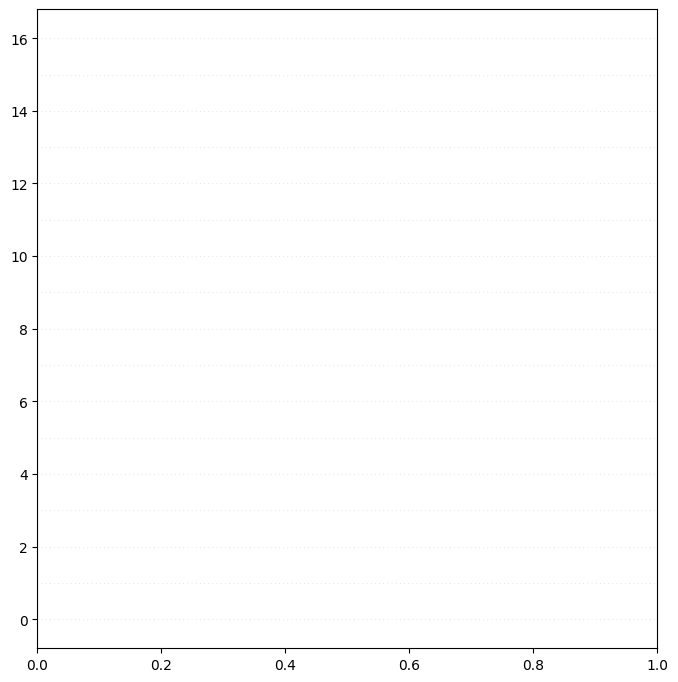

In [ ]:
"""
A simple violin summary plot
=============================

The violin summary plot offers a compact representation of the distribution and variability of SHAP 
values for each feature. Individual violin plots are stacked by importance of the particular feature 
on model output (sum of the absolute values of the SHAP values per feature).

Violin plots use “violin-shaped” figures to display the distribution and density of SHAP values for their 
respective feature. The violins can therefore provide insights into the range, variability, skewness, 
symmetry, and multimodality of the SHAP value distribution for a specific feature.

The overall violin summary plot allow for comparisons in feature importance. Wider violins indicate higher 
density and more frequent values, thus providing insights into the relative importance of each feature with 
regard to the model output.
"""
shap.plots.violin(shap_values_1, max_display=23)

In [ ]:
"""
Simple dependence scatter plot
===============================

A dependence scatter plot shows the effect a single feature has on the predictions made by the model.

* Each dot is a single prediction (row) from the dataset.
* The x-axis is the value of the feature (from the X matrix, stored in explanation.data).
* The y-axis is the SHAP value for that feature (stored in explanation.values), which represents how much knowing 
that feature’s value changes the output of the model for that sample’s prediction. For this model the units are 
log-odds of making over 50k annually.
* The light grey area at the bottom of the plot is a histogram showing the distribution of data values.
"""

features = feature_names.copy()

# for feature in features:
#     shap.plots.scatter(
#         shap_values_1[:, feature],
#         # color=shap_values_1[:, "Zone Thermal Comfort Fanger Model PMV"]
#         )

In [ ]:

# # for feature in features:
# features_copy = features.copy()
# features_copy.remove("Estado del actuador")
# for feature2 in features_copy:
#     shap.plots.scatter(
#         shap_values_1[:, "Estado del actuador"],
#         color=shap_values_1[:, feature2]
#         )

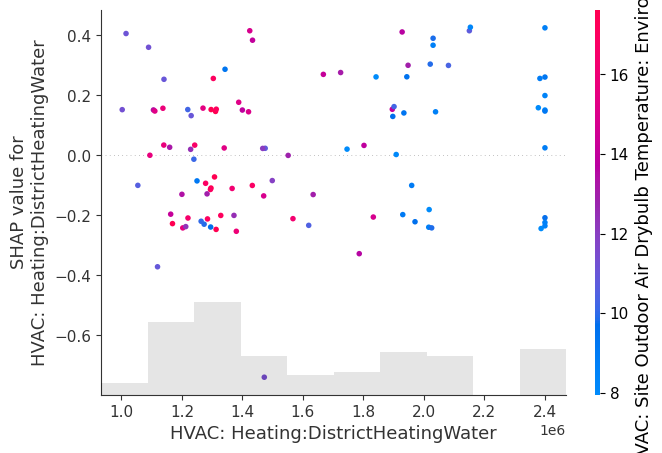

In [ ]:
shap.plots.scatter(
    shap_values_1[:, "HVAC: Heating:DistrictHeatingWater"],
    color=shap_values_1[:, "HVAC: Site Outdoor Air Drybulb Temperature: Environment"]
    )

In [ ]:
"""
Heatmap
========

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, 
the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered 
using shap.order.hclust, which orders the samples based on a hierarchical clustering by their explanation 
similarity. This results in samples that have the same model output for the same reason getting grouped together 
(such as people with a high impact from capital gain in the plot below).

The output of the model is shown above the heatmap matrix (centered around the explaination’s .base_value), and 
the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this 
is the shap.order.abs.mean measure of overall importance).
"""
shap.plots.heatmap(shap_values_1, max_display=23)

DimensionError: The hclust order only supports 2D arrays right now!

In [ ]:
# for i in range(len(background_data_np_sample)):
#     shap.initjs()
#     shap.force_plot(explainer.expected_value, shap_values[i], background_data_np_sample[i], matplotlib=True, show=True)

# for i in range(14):
#     shap.dependence_plot(i, shap_values, background_data_np_sample)

In [ ]:
# Parameter importance

# import eli5
# from eli5.sklearn import PermutationImportance

# val_X = df["observations"][0:100]
# val_y = df["actions"][0:100]

# perm = PermutationImportance(model_predict, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist())